<a href="https://colab.research.google.com/github/Arenasaurio/explanaible-steam-nlp/blob/main/notebooks/LIMEredesprofundas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b770ed80f55a8373a63c33b86a0a535230859b825ed3c8ea349485eda3cc1e4d
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

Dispositivo: cuda


In [ ]:
#el mismo modelo de antes ya que solo guardamos los pesos
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(384, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
#esto en caso de que pida acceso al drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Cargando modelo entrenado...")
model = BinaryClassifier().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/data/modelo_pytorch.pth', map_location=device))
model.eval()

Cargando modelo entrenado...


BinaryClassifier(
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
print("Cargando modelo de embeddings...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

Cargando modelo de embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print("Cargando datos...")
df = pd.read_parquet('/content/drive/MyDrive/data/Datos_Modelo.parquet')
print(f"Datos cargados: {len(df)} instancias")
print(f"Columnas: {df.columns.tolist()}")

Cargando datos...
Datos cargados: 2201192 instancias
Columnas: ['review_text', 'review_score']


In [ ]:
texts = df['review_text'].tolist()
labels_raw = df['review_score'].tolist()
# MAPEAR ETIQUETAS: -1 → 0, 1 → 1 (igual que en entrenamiento)
labels = np.array([0 if x == -1 else 1 for x in labels_raw])
print(f"Distribución de clases: {Counter(labels)}")

Distribución de clases: Counter({np.int64(1): 1100596, np.int64(0): 1100596})


In [ ]:
texts1 = []
labels1 = []

for texto, label in zip(texts, labels):
    num_palabras = len(str(texto).split())
    if num_palabras >= 30 and isinstance(texto, str) and len(texto.strip()) > 0:
        texts1.append(texto)
        labels1.append(label)

print(f"Textos válidos: {len(texts1)}/{len(texts)}")

Textos válidos: 940449/2201192


In [ ]:
print("Muestreando estratidicadamente...:v")
from sklearn.model_selection import train_test_split

sample_size = 100000
texts_sample, _, labels_sample, _ = train_test_split(
    texts1, labels1,
    train_size=sample_size,
    stratify=labels1,
    random_state=1
)

print(f"Distribución en muestra: {Counter(labels_sample)}")

Muestreando estratidicadamente...:v
Distribución en muestra: Counter({np.int64(0): 55142, np.int64(1): 44858})


In [ ]:
def predic_proba_wrapper(text_list):
    text_list_truncated = [str(t)[:512] for t in text_list]

    embeddings = embedding_model.encode(text_list_truncated, convert_to_tensor=False)
    embeddings_tensor = torch.FloatTensor(embeddings).to(device)

    with torch.no_grad():
        predictions = model(embeddings_tensor).cpu().numpy()

    prob_clase_1 = predictions
    prob_clase_0 = 1 - predictions
    probabilidades = np.hstack([prob_clase_0, prob_clase_1])

    return probabilidades

In [ ]:
lime_explainer = LimeTextExplainer(
    class_names=['Negativa', 'Positiva'],
    split_expression=r'\W+',
    random_state=42,
    bow=False  # Mantener orden de palabras
)

In [ ]:
n_explicaciones = 5000
explicaciones = []
palabras_importantes = {'positivas': [], 'negativas': []}

for i in tqdm(range(min(n_explicaciones, len(texts_sample))), desc="..."):
    texto = texts_sample[i]

    explicacion = lime_explainer.explain_instance(
        texto,
        predic_proba_wrapper,
        num_features=15,
        num_samples=500
    )

    explicaciones.append({
        'texto': texto,
        'label_real': labels_sample[i],
        'explicacion': explicacion
    })

    for palabra, peso in explicacion.as_list():
        palabras_importantes['positivas'].append((palabra, peso)) if peso > 0 else palabras_importantes['negativas'].append((palabra, peso))

...: 100%|██████████| 5000/5000 [1:29:34<00:00,  1.07s/it]


In [ ]:
top_positivas = Counter(dict(palabras_importantes['positivas'])).most_common(30)
top_negativas = Counter(dict(palabras_importantes['negativas'])).most_common(30)

palabras_pos, pesos_pos = zip(*top_positivas)
palabras_neg, pesos_neg = zip(*top_negativas)
pesos_neg = [abs(p) for p in pesos_neg]

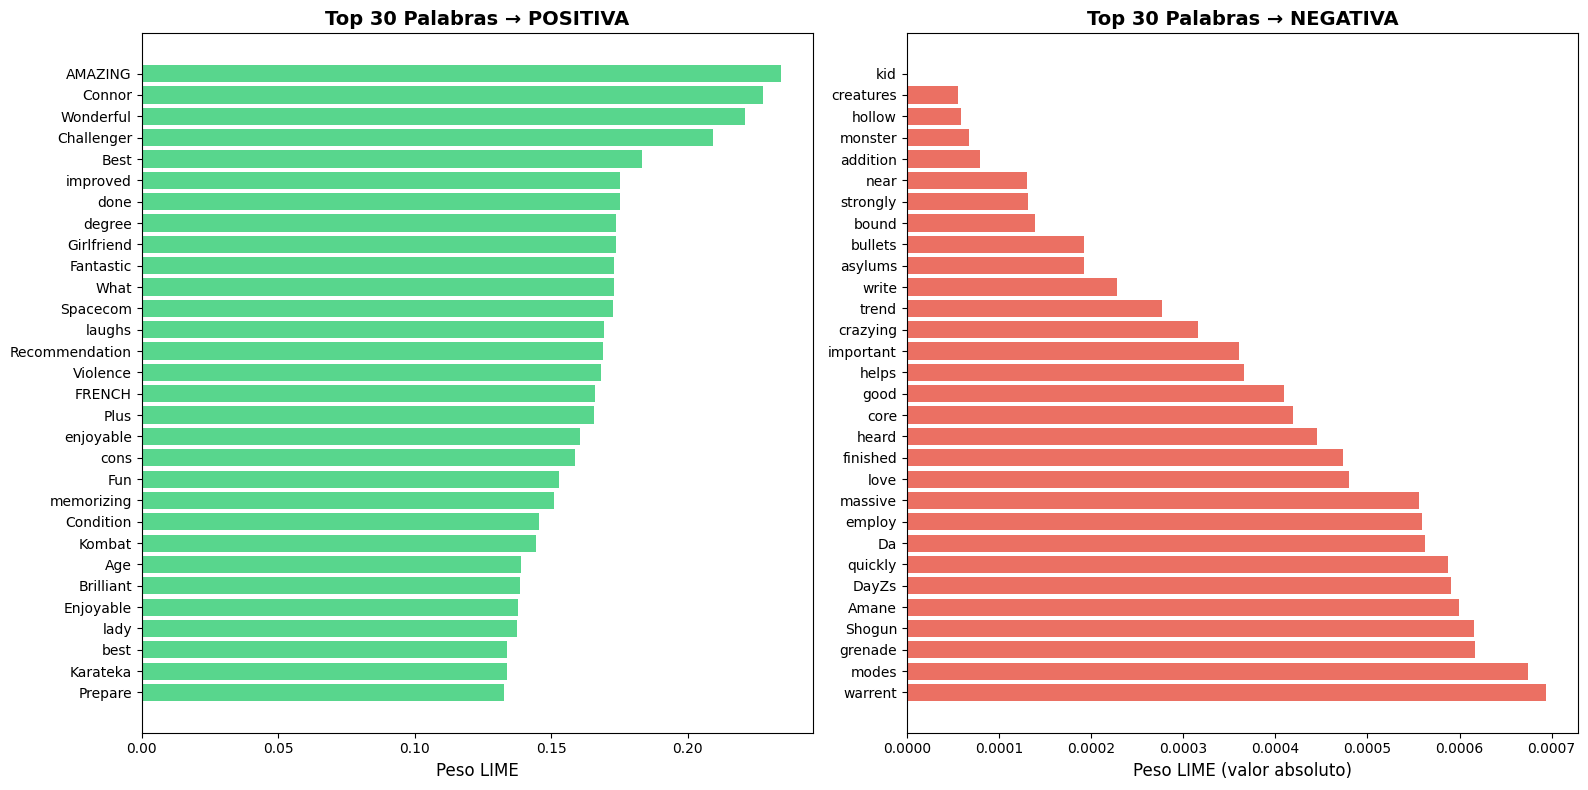

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.barh(range(len(palabras_pos)), pesos_pos, color='#2ecc71', alpha=0.8)
ax1.set_yticks(range(len(palabras_pos)))
ax1.set_yticklabels(palabras_pos)
ax1.set_xlabel('Peso LIME', fontsize=12)
ax1.set_title('Top 30 Palabras → POSITIVA', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

ax2.barh(range(len(palabras_neg)), pesos_neg, color='#e74c3c', alpha=0.8)
ax2.set_yticks(range(len(palabras_neg)))
ax2.set_yticklabels(palabras_neg)
ax2.set_xlabel('Peso LIME (valor absoluto)', fontsize=12)
ax2.set_title('Top 30 Palabras → NEGATIVA', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('lime_palabras_importantes.png')
plt.show()

In [ ]:
predicciones_correctas = [e for e in explicaciones if (e['explicacion'].predict_proba[1] > 0.5) == e['label_real']]
predicciones_incorrectas = [e for e in explicaciones if (e['explicacion'].predict_proba[1] > 0.5) != e['label_real']]
print(f"Porcentaje de predicciones correctas: {(len(predicciones_correctas)/len(explicaciones))*100}%")
print(f"Porcentaje de predicciones incorrectas: {(len(predicciones_incorrectas)/len(explicaciones))*100}%")

Porcentaje de predicciones correctas: 83.84%
Porcentaje de predicciones incorrectas: 16.16%


In [ ]:
ejemplo = predicciones_correctas[0] if predicciones_correctas else explicaciones[0]
print(f"Ejemplo Texto: {ejemplo['texto'][:300]}...")
print(f"Label real: {'POSITIVA' if ejemplo['label_real'] else 'NEGATIVA'}")
print(f"Predicción: {ejemplo['explicacion'].predict_proba[1]:.3f}")
print("\nPalabras más influyentes:")
for palabra, peso in ejemplo['explicacion'].as_list()[:10]:
    signo = "→ POSITIVO" if peso > 0 else "→ NEGATIVO"
    print(f"  '{palabra}': {peso:+.3f} {signo}")

Ejemplo Texto: I'm into really grindy &amp; tycoon style games, and his game was interesting to say nonetheless. You go through this 'simulated process' of building your character to becoming a professional fighter; from doing newspaper jobs, delivering pizzas, buying equipment for your house, going to the gym if ...
Label real: POSITIVA
Predicción: 0.883

Palabras más influyentes:
  'm': +0.045 → POSITIVO
  'simulated': -0.045 → NEGATIVO
  'I': +0.043 → POSITIVO
  'strengths': +0.040 → POSITIVO
  'was': -0.040 → NEGATIVO
  'into': +0.028 → POSITIVO
  'nonetheless': -0.022 → NEGATIVO
  'lot': -0.019 → NEGATIVO
  'your': +0.018 → POSITIVO
  'say': +0.014 → POSITIVO


In [ ]:
ejemplo = predicciones_incorrectas[0] if predicciones_incorrectas else explicaciones[1]
print(f"Texto: {ejemplo['texto'][:300]}...")
print(f"Label real: {'POSITIVA' if ejemplo['label_real'] else 'NEGATIVA'}")
print(f"Predicción: {ejemplo['explicacion'].predict_proba[1]:.3f}")
print("\nPalabras más influyentes:")
for palabra, peso in ejemplo['explicacion'].as_list()[:10]:
    signo = "→ POSITIVO" if peso > 0 else "→ NEGATIVO"
    print(f"  '{palabra}': {peso:+.3f} {signo}")

Texto:   Oh hello there! If you like co-op and shooting things, reparing drills, throwing bags around and grinding the same mission to get a mask in the card selection screen then this game is for you. Very fun to play with friends, especially if you all take up different roles. For example one keeping the...
Label real: NEGATIVA
Predicción: 0.987

Palabras más influyentes:
  'fun': +0.035 → POSITIVO
  'roles': +0.034 → POSITIVO
  'card': -0.034 → NEGATIVO
  'friends': +0.034 → POSITIVO
  'you': +0.026 → POSITIVO
  'you': +0.021 → POSITIVO
  'armour': +0.020 → POSITIVO
  'same': -0.019 → NEGATIVO
  'Stealth': +0.017 → POSITIVO
  'different': -0.017 → NEGATIVO


In [ ]:
resultados_df = pd.DataFrame([
    {
        'texto': e['texto'],
        'label_real': e['label_real'],
        'prediccion': e['explicacion'].predict_proba[1],
        'top_palabras': str(e['explicacion'].as_list()[:10])
    }
    for e in explicaciones
])

resultados_df.to_csv('explicaciones_lime.csv', index=False)
palabras_df = pd.DataFrame({
    'palabra': list(palabras_pos) + list(palabras_neg),
    'peso': list(pesos_pos) + [-p for p in pesos_neg],
    'tipo': ['positiva']*len(palabras_pos) + ['negativa']*len(palabras_neg)
})
palabras_df.to_csv('palabras_importantes.csv', index=False)